In [1]:
import pandas as pd
import json

# Load the JSON file
with open('data/recipes/recipes_images.json') as f:
    data = json.load(f)

# Normalize the JSON data
df = pd.json_normalize(data)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20935 entries, 0 to 20934
Data columns (total 96 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   title                       20935 non-null  object 
 1   description                 17316 non-null  object 
 2   ingredients                 20927 non-null  object 
 3   cooking_time                4450 non-null   float64
 4   servings                    9172 non-null   float64
 5   publish_date                20935 non-null  object 
 6   image_filename              20935 non-null  object 
 7   instructions.1              20916 non-null  object 
 8   instructions.2              18045 non-null  object 
 9   instructions.3              14962 non-null  object 
 10  ratings.rating              12653 non-null  float64
 11  ratings.count               12653 non-null  float64
 12  tags.type                   15605 non-null  object 
 13  tags.cuisine                872

In [2]:
# List of columns to keep
columns_to_keep = [
    'title',
    'ratings.rating',
    'ratings.count',
    'tags.special-consideration'
]

# Create a new DataFrame with only the columns to keep
df_filtered = df[columns_to_keep]

# Display the first few rows of the filtered DataFrame
df_filtered

# Display the structure of the filtered DataFrame
df_filtered.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20935 entries, 0 to 20934
Data columns (total 4 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   title                       20935 non-null  object 
 1   ratings.rating              12653 non-null  float64
 2   ratings.count               12653 non-null  float64
 3   tags.special-consideration  18951 non-null  object 
dtypes: float64(2), object(2)
memory usage: 654.3+ KB


In [3]:
df_filtered.isnull().sum()

title                            0
ratings.rating                8282
ratings.count                 8282
tags.special-consideration    1984
dtype: int64

In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from scipy.stats.mstats import winsorize

processed_df = df_filtered.copy()

# 1. Handle missing ratings
# Create imputer for numerical columns
num_imputer = SimpleImputer(strategy='mean')

# 2.Fill missing ratings and counts
numerical_cols = ['ratings.rating', 'ratings.count']
processed_df[numerical_cols] = num_imputer.fit_transform(processed_df[numerical_cols])


# 3. Process special considerations
processed_df = processed_df.dropna(subset=['tags.special-consideration'])
processed_df['tags.special-consideration'] = processed_df['tags.special-consideration'].apply(
        lambda x: ','.join(x) if isinstance(x, list) else x
    )


# 4. One-hot encoding
special_considerations = processed_df['tags.special-consideration'].str.split(',').apply(
    lambda x: pd.Series(1, index=x)
).fillna(0).astype(int)

# 5.Winsorize 'ratings.rating'
processed_df['ratings.rating'] = winsorize(processed_df['ratings.rating'], limits=[0.05, 0.05]) # Caps at 5th and 95th percentiles

processed_df['high_ratings_count'] = np.where(processed_df['ratings.count'] >= processed_df['ratings.count'].median(), 1, 0)
# 6.Concatenate the dummy variables with the processed dataframe
cleaned_df = pd.concat([processed_df, special_considerations], axis=1)

# 7.Drop original special consideration column
cleaned_df = cleaned_df.drop(['tags.special-consideration'], axis=1)
cleaned_df.columns

Index(['title', 'ratings.rating', 'ratings.count', 'high_ratings_count',
       'Nut Free', 'Vegetarian', 'Dairy Free', 'Gluten Free', 'Keto', 'Vegan',
       'Raw', 'Healthyish', 'Pescatarian', 'Soy Free', 'Kosher', 'Low Carb',
       'Quick & Easy', 'Fat Free', 'Kid-Friendly', 'Sugar Conscious', 'Paleo',
       'Low Cal', 'Low Fat'],
      dtype='object')

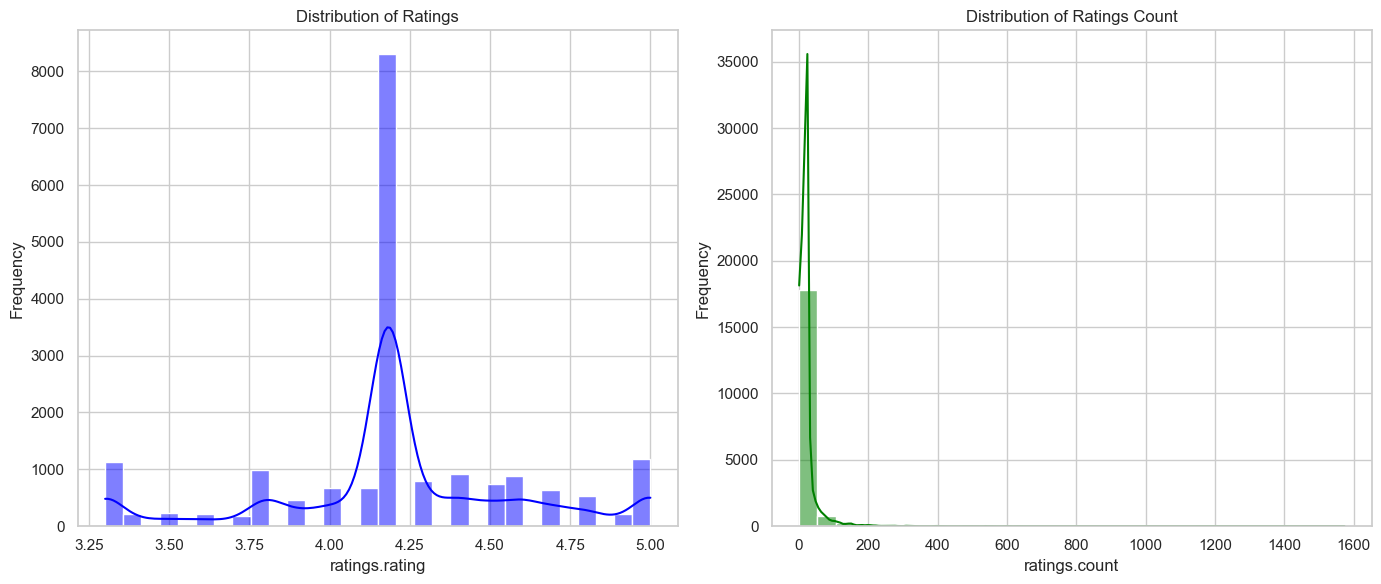

C:\Users\BU\AppData\Local\Temp\ipykernel_4516\1519697688.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=binary_sum.values, y=binary_sum.index, palette="viridis")


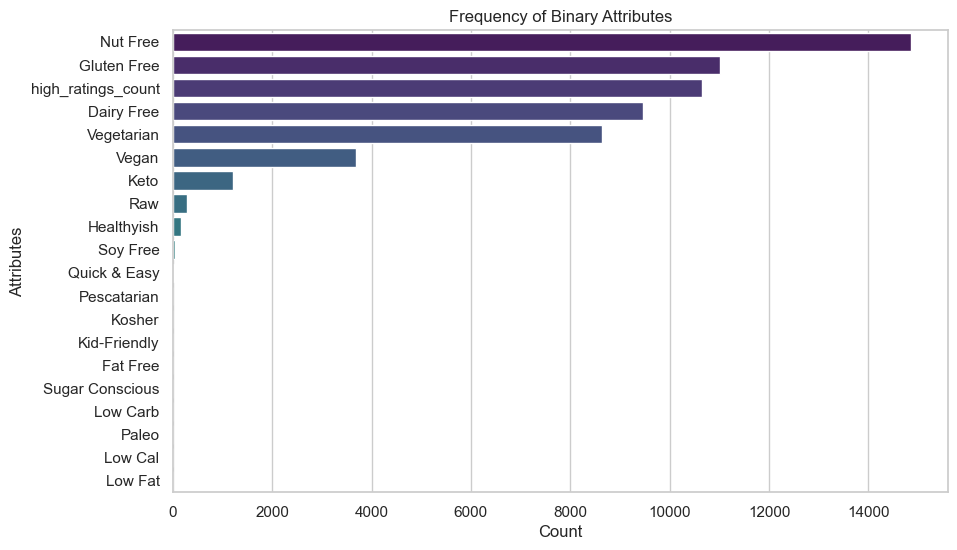

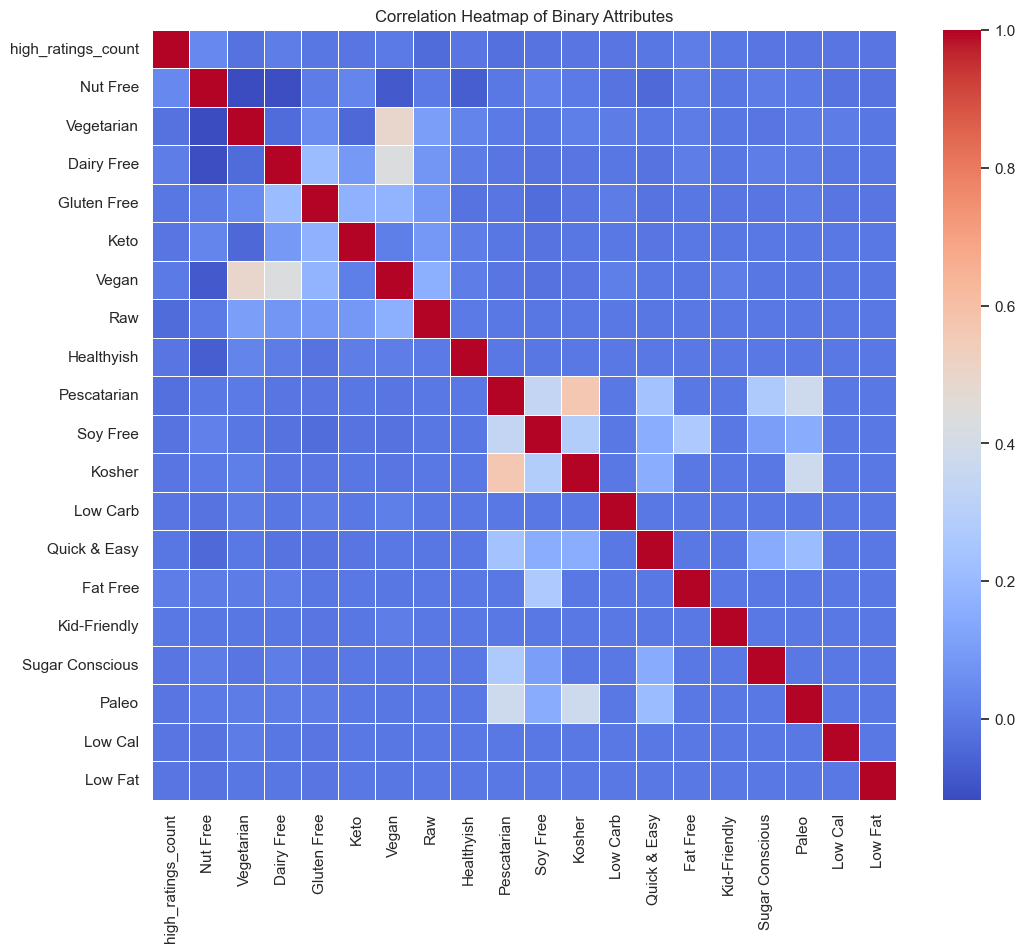

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set a visual theme for seaborn
sns.set_theme(style="whitegrid")

# Distribution plots for 'ratings.rating' and 'ratings.count'
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.histplot(cleaned_df['ratings.rating'], kde=True, color="blue", bins=30)
plt.title("Distribution of Ratings")
plt.xlabel("ratings.rating")
plt.ylabel("Frequency")

plt.subplot(1, 2, 2)
sns.histplot(cleaned_df['ratings.count'], kde=True, color="green", bins=30)
plt.title("Distribution of Ratings Count")
plt.xlabel("ratings.count")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

# Bar chart for binary attributes
binary_cols = cleaned_df.columns[3:]
binary_sum = cleaned_df[binary_cols].sum().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=binary_sum.values, y=binary_sum.index, palette="viridis")
plt.title("Frequency of Binary Attributes")
plt.xlabel("Count")
plt.ylabel("Attributes")
plt.show()

# Heatmap for correlation among binary attributes
plt.figure(figsize=(12, 10))
corr_matrix = cleaned_df[binary_cols].corr()
sns.heatmap(corr_matrix, annot=False, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap of Binary Attributes")
plt.show()


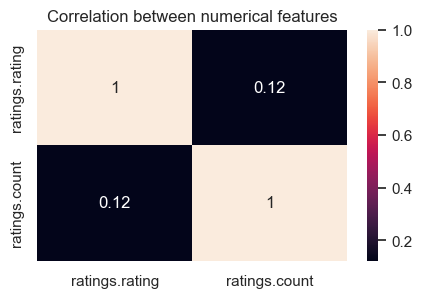

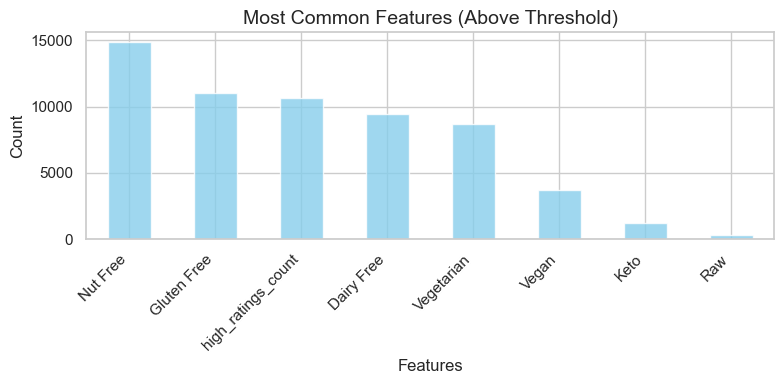

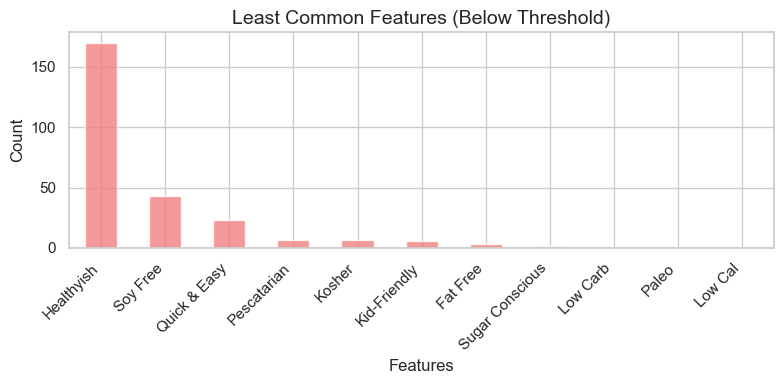

In [32]:
# Check feature importance and correlation
import seaborn as sns
import matplotlib.pyplot as plt

# Correlation analysis for numerical features
correlation = cleaned_df[['ratings.rating', 'ratings.count']].corr()
plt.figure(figsize=(5,3))
sns.heatmap(correlation, annot=True)
plt.title('Correlation between numerical features')
plt.show()

# Define threshold for categorization
special_consideration_threshold = 200

# Identify most and least common features based on the threshold
most_common_features = special_consideration_counts[special_consideration_counts > special_consideration_threshold]
least_common_features = special_consideration_counts[special_consideration_counts < special_consideration_threshold]

# Plot most common features
plt.figure(figsize=(8, 4))
most_common_features.plot(kind='bar', color='skyblue', alpha=0.8)
plt.title('Most Common Features (Above Threshold)', fontsize=14)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Features', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Plot least common features
plt.figure(figsize=(8, 4))
least_common_features.plot(kind='bar', color='lightcoral', alpha=0.8)
plt.title('Least Common Features (Below Threshold)', fontsize=14)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Features', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [39]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

# Step 1: Define Features (X) and Target (y)
binary_cols = cleaned_df.columns[4:]
X = cleaned_df[binary_cols]
y = cleaned_df['ratings.rating']

# Step 2: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Model Training and Evaluation Function
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return mse, r2

# Step 4: Initialize Models
models = {
    "Linear Regression": LinearRegression(),
    "Gradient Boosting Regressor": GradientBoostingRegressor(random_state=42),
    "Random Forest Regressor": RandomForestRegressor(random_state=42),
}

# Step 5: Evaluate All Models
results = {}
for model_name, model in models.items():
    mse, r2 = evaluate_model(model, X_train, y_train, X_test, y_test)
    accuracy = 1 - (mse / np.var(y_test))  # Accuracy Calculation
    print("Accuracy (train) for %s: %0.1f%%" % (model_name, accuracy * 100))
    results[model_name] = {"MSE": mse, "R2": r2, "Accuracy": accuracy}

# Display Results
results


Accuracy (train) for Linear Regression: 1.2%
Accuracy (train) for Gradient Boosting Regressor: 0.9%
Accuracy (train) for Random Forest Regressor: 0.4%


{'Linear Regression': {'MSE': 0.15332041864297752,
  'R2': 0.011786586867504112,
  'Accuracy': 0.011786586867504},
 'Gradient Boosting Regressor': {'MSE': 0.15378324494712106,
  'R2': 0.008803480209217174,
  'Accuracy': 0.008803480209217174},
 'Random Forest Regressor': {'MSE': 0.15450531931130687,
  'R2': 0.004149412745253822,
  'Accuracy': 0.004149412745253711}}


Cluster Statistics:
                      title ratings.rating       ratings.count
                      count           mean   std          mean
hierarchical_cluster                                          
1                      3691           4.20  0.40         18.79
2                        11           3.85  0.59         17.64
3                     15249           4.21  0.39         23.41

Most Distinctive Features in Each Cluster:

Cluster 1 Top Features:
Vegan          0.747738
Vegetarian     0.475986
Dairy Free     0.411080
Gluten Free    0.160449
Raw            0.062831
dtype: float64

Cluster 2 Top Features:
Kosher             0.635994
Pescatarian        0.635994
Soy Free           0.634095
Quick & Easy       0.362423
Sugar Conscious    0.181713
dtype: float64

Cluster 3 Top Features:
hierarchical_cluster    0.390111
Nut Free                0.018930
Keto                    0.010112
Soy Free                0.000092
Fat Free                0.000038
dtype: float64


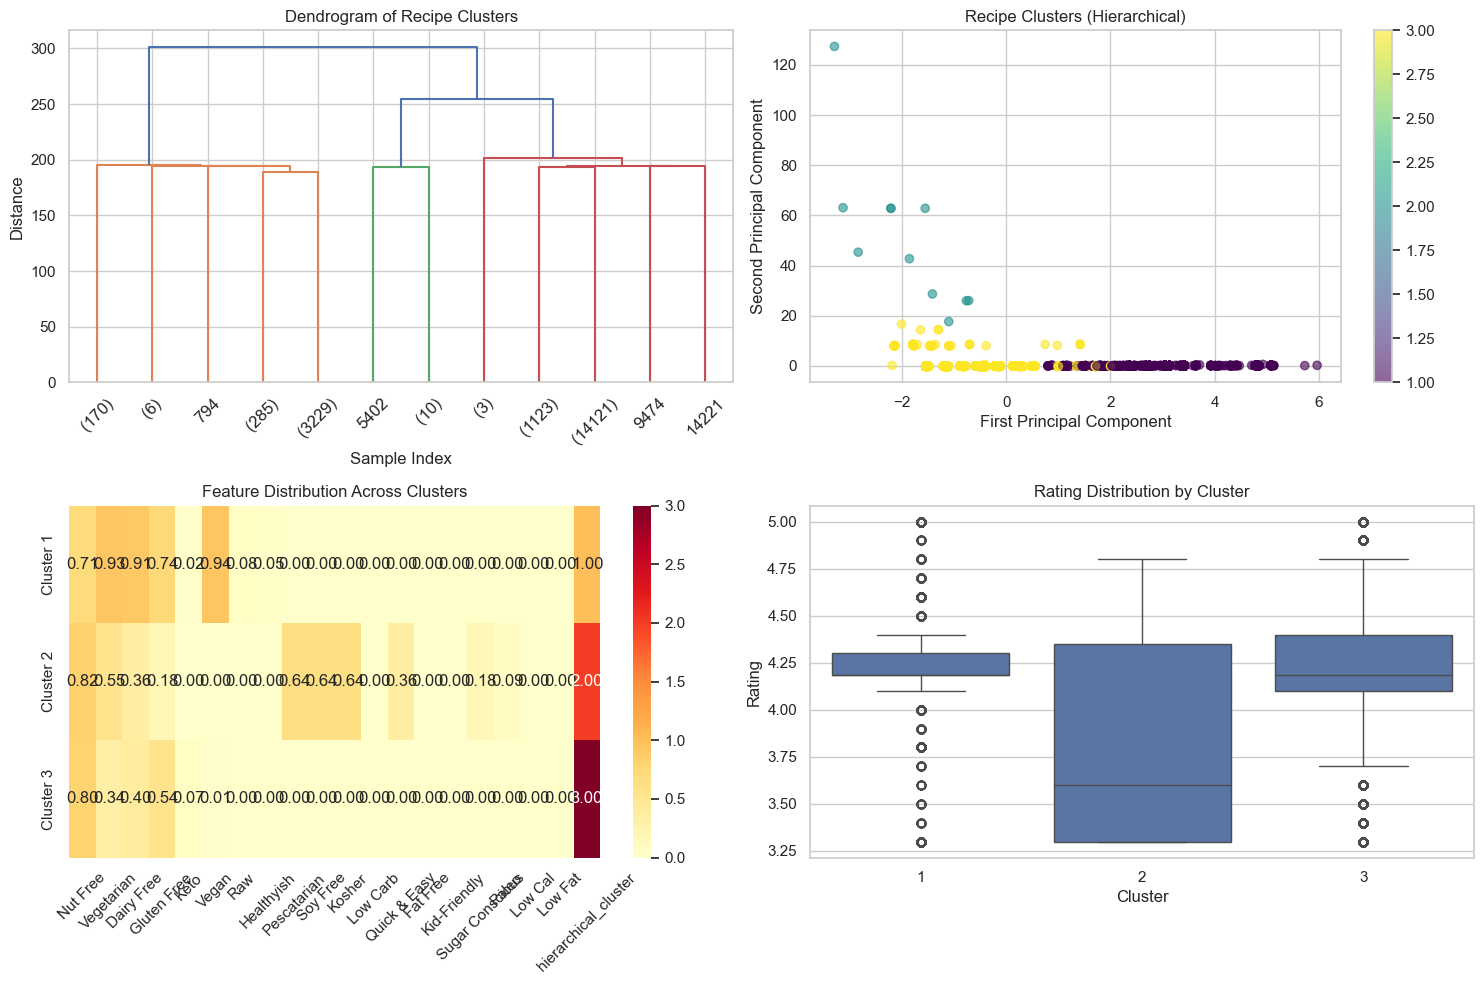

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist

# Veriyi hazırlama
feature_columns = cleaned_df.columns[4:]  # Özellik kolonlarını seç
feature_columns = feature_columns[feature_columns != 'rating_category'] # Exclude 'rating_category'
X = cleaned_df[feature_columns]


# Verileri standardize et
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Hierarchical Clustering uygula
linkage_matrix = linkage(X_scaled, method='ward', metric='euclidean')

# Optimal küme sayısını belirle
plt.figure(figsize=(15, 10))

# 1. Dendrogram
plt.subplot(2, 2, 1)
dendrogram(linkage_matrix, truncate_mode='lastp', p=12, leaf_rotation=45)
plt.title('Dendrogram of Recipe Clusters')
plt.xlabel('Sample Index')
plt.ylabel('Distance')

# Kümeleri oluştur (3 küme için)
clusters = fcluster(linkage_matrix, 3, criterion='maxclust')
cleaned_df['hierarchical_cluster'] = clusters

# PCA uygula
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# 2. Scatter Plot
plt.subplot(2, 2, 2)
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], 
                     c=clusters, 
                     cmap='viridis',
                     alpha=0.6)
plt.title('Recipe Clusters (Hierarchical)')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.colorbar(scatter)

# 3. Özellik dağılımları
plt.subplot(2, 2, 3)
cluster_features = pd.DataFrame()
for i in range(1, 4):  # 3 küme için
    means = cleaned_df[cleaned_df['hierarchical_cluster'] == i][feature_columns].mean()
    cluster_features[f'Cluster {i}'] = means

cluster_features = cluster_features.T
sns.heatmap(cluster_features, cmap='YlOrRd', annot=True, fmt='.2f')
plt.title('Feature Distribution Across Clusters')
plt.xticks(rotation=45)

# 4. Rating dağılımları
plt.subplot(2, 2, 4)
sns.boxplot(x='hierarchical_cluster', y='ratings.rating', data=cleaned_df)
plt.title('Rating Distribution by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Rating')

plt.tight_layout()

# Küme istatistikleri
cluster_stats = cleaned_df.groupby('hierarchical_cluster').agg({
    'title': 'count',
    'ratings.rating': ['mean', 'std'],
    'ratings.count': 'mean'
}).round(2)

print("\nCluster Statistics:")
print(cluster_stats)

# Her kümedeki en belirgin özellikleri bul
print("\nMost Distinctive Features in Each Cluster:")
for cluster in range(1, 4):
    cluster_data = cleaned_df[cleaned_df['hierarchical_cluster'] == cluster]
    cluster_means = cluster_data[feature_columns].mean()
    overall_means = cleaned_df[feature_columns].mean()
    
    # Özellik farklılıklarını hesapla
    differences = (cluster_means - overall_means).sort_values(ascending=False)
    print(f"\nCluster {cluster} Top Features:")
    print(differences.head(5))

In [42]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# Kümeleme Kalite Metrikleri
silhouette_avg = silhouette_score(X_scaled, clusters)
calinski_harabasz = calinski_harabasz_score(X_scaled, clusters)
davies_bouldin = davies_bouldin_score(X_scaled, clusters)

print("\nClustering Quality Metrics:")
print(f"Silhouette Score: {silhouette_avg:.2f} (Higher is better, range: -1 to 1)")
print(f"Calinski-Harabasz Index: {calinski_harabasz:.2f} (Higher is better)")
print(f"Davies-Bouldin Index: {davies_bouldin:.2f} (Lower is better)")



Clustering Quality Metrics:
Silhouette Score: 0.45 (Higher is better, range: -1 to 1)
Calinski-Harabasz Index: 2445.79 (Higher is better)
Davies-Bouldin Index: 1.23 (Lower is better)
